# Bayesian Optimisation 

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

## Gaussian Process Regression
A Gaussian Process is an infinite collection of random variables, where any input $\boldsymbol{x} \in \mathbb{R}^d$ is mapped to a random variable $f(\boldsymbol{x})$, such that the joint distribution of any finite subset of size $n$ of these random variables forms a multivariate Gaussian distribution: 

\begin{align}
p(\boldsymbol{f} \ | \boldsymbol{X}) &= \frac{1}{(2 \pi)^{d/2} |\boldsymbol{\Sigma}|^{1/2}} \exp \Big( - \frac{1}{2} (\boldsymbol{f} - \boldsymbol{\mu})^T \boldsymbol{\Sigma}^{-1} (\boldsymbol{f} - \boldsymbol{\mu}) \Big)\\
\end{align}

where $\boldsymbol{X} \in \mathbb{R}^{n \times d}$ and $\boldsymbol{f} \in \mathbb{R}^{n} $ is a vector  $[f(\boldsymbol{x_1}), f(\boldsymbol{x_2}), ..., f(\boldsymbol{x_n})]$. The mean parameter $\boldsymbol{\mu}$ is often set to 0, thus  

\begin{align}
p(\boldsymbol{f} \ | \boldsymbol{X}) = \mathcal{N}(\boldsymbol{0}, \boldsymbol{\Sigma})
\end{align}

The covariance matrix $\boldsymbol{\Sigma}$ is constructed from the inputs $\boldsymbol{X}$. A common choice for $\boldsymbol{\Sigma}$ is the RBF-Kernel:

\begin{align}
\Sigma_{ij} &= \exp\Big(-\gamma (\boldsymbol{x_i} - \boldsymbol{x_j})^T(\boldsymbol{x_i} - \boldsymbol{x_j})\Big)\\
&= \exp\Big(-\gamma (\boldsymbol{x_i}^T\boldsymbol{x_i} + \boldsymbol{x_j}^T\boldsymbol{x_j} - 2\boldsymbol{x_i}^T\boldsymbol{x_j})\Big)
\end{align}

In [2]:
def RBF_kernel(X_1, X_2, gamma=1.0):
    '''
    Assume X_1 and X_2 are 1-dimensional vectors i.e. d=1.
    '''
    distance_matrix = (X_1**2).reshape(-1, 1) + X_2**2 - 2*np.outer(X_1, X_2)
    return np.exp(-gamma * distance_matrix)

Properties of multivariate Gaussian distributions allow us to decompose the joint distribution for the observed values $\boldsymbol{f}$ and the unobserved values $\boldsymbol{f_*}$:

$p(\boldsymbol{f}, \ \boldsymbol{f_*} \ | \boldsymbol{X},\ \boldsymbol{X_*}) = \mathcal{N}\Bigg(\boldsymbol{0}, \begin{pmatrix}
  \boldsymbol{K} & \boldsymbol{K_*}\\ 
  \boldsymbol{K_*^T} & \boldsymbol{K_{**}}
\end{pmatrix} \Bigg) $

where $\boldsymbol{K}$ is the training kernel matrix, $\boldsymbol{K_*}$ is the training-testing kernel matrix and $\boldsymbol{K_{**}}$  is the testing kernel matrix.

Posterior predictive for the unobserved $\boldsymbol{f_*}$ can be obtained by taking advantage of the conditioning properties of Gaussian distribution:

\begin{align}
p(\boldsymbol{f_*} \ | \ \boldsymbol{f}, \  \boldsymbol{X},\ \boldsymbol{X_*}) = \mathcal{N}\big(\boldsymbol{K_*^T K^{-1} f}, \ \boldsymbol{K_{**}} - \boldsymbol{K_*^T K^{-1} K_*} \big)
\end{align}

In [3]:
def GP_posterior_predictive(X_new, X_observed, Y_observed):
    """
    Return means and standard deviations of the marginalised
    posterior predictive distribution for the new points.
    """              
    # Compute Kernels
    K = RBF_kernel(X_observed, X_observed)
    K_inv = np.linalg.inv(K)
    K_s = RBF_kernel(X_observed, X_new)
    K_ss = RBF_kernel(X_new, X_new)
    
    # Get means for the posterior predictive distribution
    mu_new = np.dot(np.dot(K_s.T, K_inv), Y_observed)
    
    # Get covariance matrix for the posterior predictive distribution
    cov_new = K_ss - np.dot(K_s.T, np.dot(K_inv, K_s))
    
    # Get the standard deviations of the marginalised posterior predictive distribution
    sigma_new = np.sqrt(np.diag(cov_new))
    
    return mu_new, sigma_new

## Example

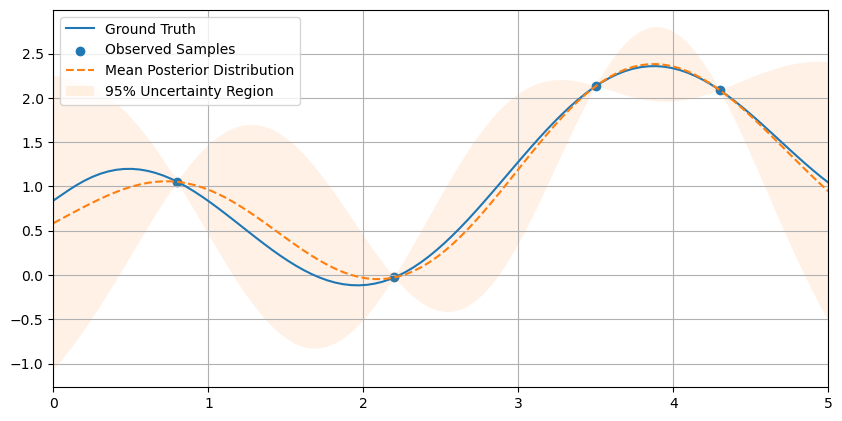

In [4]:
# The unknown function f
def f(X):
    return np.sin(X*1.8+1) + np.power(X, 1.4) / (X+1)

# Domain range                            
X_range = np.linspace(0, 5, 100)
                            
# Observed samples
X_observed = np.array([0.8, 2.2, 3.5, 4.3])
Y_observed = f(X_observed)

# Means and Standard deviations of the marginalised posterior predictive distribution for the domain
mu_pos_pred, sigma_pos_pred = GP_posterior_predictive(X_range, X_observed, Y_observed)                          

# Plot
plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')                            
plt.plot(X_range, f(X_range), label="Ground Truth")
plt.scatter(X_observed, Y_observed, label="Observed Samples")
plt.plot(X_range, mu_pos_pred, ls='--', label="Mean Posterior Distribution")
plt.fill_between(X_range, mu_pos_pred-1.96*sigma_pos_pred, mu_pos_pred+1.96*sigma_pos_pred, label="95% Uncertainty Region", alpha=0.1)
plt.xlim(X_range[0], X_range[-1])
plt.grid()
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,2,1,3]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

## Acquisition Function

Bayesian optimisation allows us to find the optimum of an unknown function that is very expensive to evaluate. A *surrogate model* is used to approximate this unknown function, and Gaussian Processes are a common choice for this as their posterior predictive is cheap to evaluate.

The *acquisition function* helps determine the best sampling points within the search space where the unknown function should be evaluated. This can be written as:

\begin{align}
\boldsymbol{x_t} = argmax_x \mathcal{A} \big(\boldsymbol{x} \ | \ \boldsymbol{x_1},\ f(\boldsymbol{x_1}),\ \boldsymbol{x_2},\ f(\boldsymbol{x_2}),\ ...,\ \boldsymbol{x_{t-1}},\ f(\boldsymbol{x_{t-1}})\big)
\end{align}

A popular choice for the acquisition function is the *expected improvement*:
\begin{equation}
  EI(\boldsymbol{x}) =
    \begin{cases}
      \big( \mu(\boldsymbol{x}) − f^+ − \xi\big) \Phi(Z) + \sigma(\boldsymbol{x}) \phi(Z) & \text{if} \ \sigma(\boldsymbol{x})>0\\
      0 & \text{if} \ \sigma(\boldsymbol{x})=0\\
    \end{cases}       
\end{equation}

where:
\begin{equation}
  Z =
    \begin{cases}
      \frac{\mu(\boldsymbol{x}) − f^+ − \xi}{\sigma(\boldsymbol{x})} & \text{if} \ \sigma(\boldsymbol{x})>0\\
      0 & \text{if} \ \sigma(\boldsymbol{x})=0\\
    \end{cases}       
\end{equation}

and where $\mu(\boldsymbol{x})$ and $\sigma(\boldsymbol{x})$ are the mean and standard deviation of the Gaussian Process posterior predictive distribution at $\boldsymbol{x}$, $f^+ = max \{ f(\boldsymbol{x_1}),\ f(\boldsymbol{x_2}),\ ...,\ f(\boldsymbol{x_{t-1}}) \}$, and $\Phi$ and $\phi$ are the cumulative distribution function and probability density function of the standard Gaussian distribution, respectively. The parameter $\xi$ controls the trade-off between exploration vs. exploitation during optimisation.

In [5]:
def expected_improvement(X, X_observed, Y_observed, xi=0.01):
    '''
    Returns the expected improvement at points X based on the 
    observed samples X_observed and Y_observed.
    '''
    # Find the mean and standard deviation of the  GP posterior predictive distribution at each point.
    mu, sigma = GP_posterior_predictive(X, X_observed, Y_observed)
    
    # Find the best observed sample so far.
    Y_best = np.max(Y_observed)
    
    # Compute Z
    improvement = mu - Y_best - xi
    improvement[sigma==0] = 0
    
    Z = np.divide(improvement, sigma, out=np.zeros_like(sigma), where=sigma!=0) 
    
    # Compute expected improvement
    ei = improvement * norm.cdf(Z) + sigma * norm.pdf(Z)

    return ei

## Optimisation Algorithm

1. Find the next best sampling point $\boldsymbol{x_t}$ from the acquisition function using the previously observed samples $\{(\boldsymbol{x_1},\ f(\boldsymbol{x_1})),\ (\boldsymbol{x_2},\ f(\boldsymbol{x_2})),\ ...,\ (\boldsymbol{x_{t-1}},\ f(\boldsymbol{x_{t-1}})) \}$

2. Evaluate the function $f$ at $\boldsymbol{x_t}$.

3. Append the newly observed sample to the set of previously observed samples: $\{(\boldsymbol{x_1},\ f(\boldsymbol{x_1})),\ (\boldsymbol{x_2},\ f(\boldsymbol{x_2})),\ ...,\ (\boldsymbol{x_{t-1}},\ f(\boldsymbol{x_{t-1}})),\ (\boldsymbol{x_{t}},\ f(\boldsymbol{x_{t}})) \}$

4. Repeat

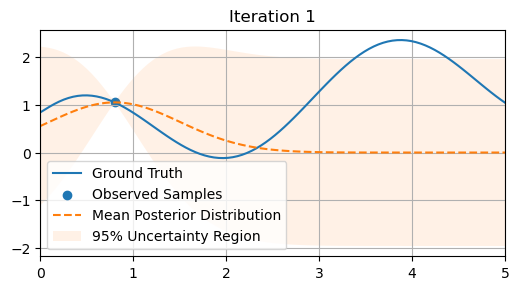

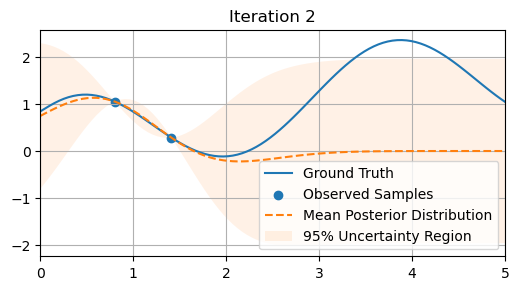

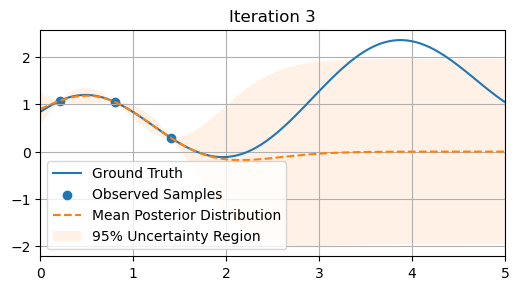

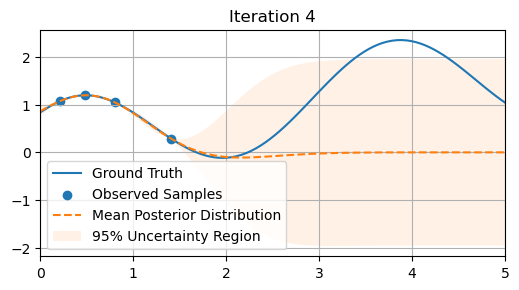

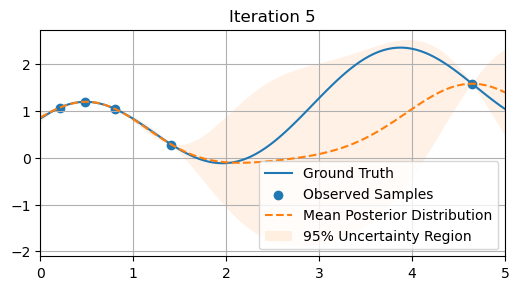

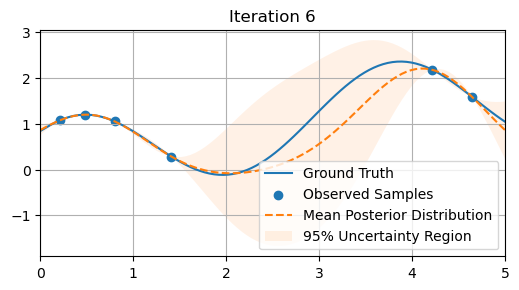

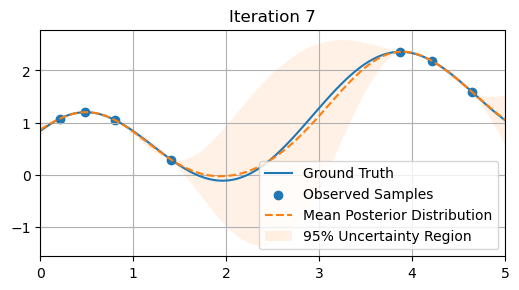

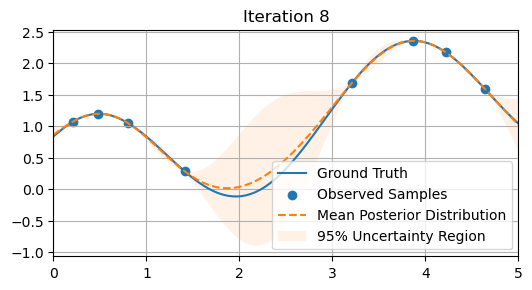

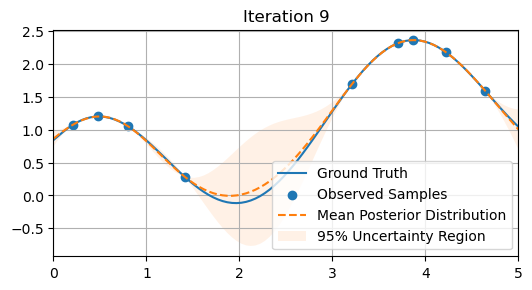

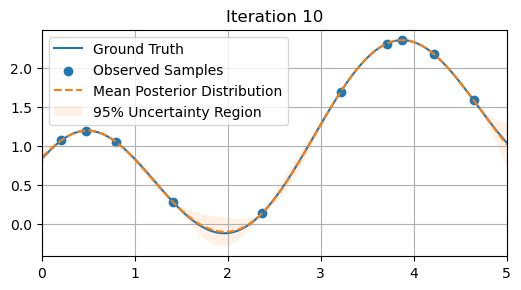

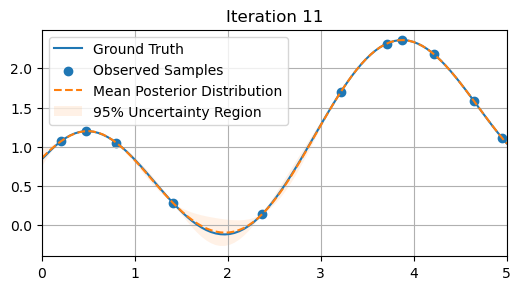

In [6]:
# Number of iterations
n_iterations = 10

# Domain range                            
X_range = np.linspace(0, 5, 100)

# Initial set of observed samples
X_observed = np.array([0.8])
Y_observed = f(X_observed)

# Posterior predictive distribution for the domain
mu_pos_pred, sigma_pos_pred = GP_posterior_predictive(X_range, X_observed, Y_observed) 

# Plot
plt.figure(figsize=(6,3), dpi= 100, facecolor='w', edgecolor='k')
plt.title(f"Iteration {1}")
plt.plot(X_range, f(X_range), label="Ground Truth")
plt.scatter(X_observed, Y_observed, label="Observed Samples")
plt.plot(X_range, mu_pos_pred, ls='--', label="Mean Posterior Distribution")
plt.fill_between(X_range, mu_pos_pred-1.96*sigma_pos_pred, mu_pos_pred+1.96*sigma_pos_pred, label="95% Uncertainty Region", alpha=0.1)
plt.xlim(X_range[0], X_range[-1])
plt.grid()
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,2,1,3]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

# Iterate
for i in range(n_iterations):
    # Random search for next best sampling point
    X_trial = np.random.uniform(X_range[0], X_range[-1], size=50)
    EIs = expected_improvement(X_trial, X_observed, Y_observed)
    
    # Find the sample with the best expected improvement
    x_trial = X_trial[np.argmax(EIs)]
    
    # Evaluate the function at best point
    y_trial = f(x_trial)
    
    # Append the newly observed sample to the set previously observed samples
    X_observed = np.append(X_observed, x_trial)
    Y_observed = np.append(Y_observed, y_trial)

    # Posterior predictive distribution for the domain
    mu_pos_pred, sigma_pos_pred = GP_posterior_predictive(X_range, X_observed, Y_observed) 

    # Plot
    plt.figure(figsize=(6,3), dpi= 100, facecolor='w', edgecolor='k') 
    plt.title(f"Iteration {i+2}")
    plt.plot(X_range, f(X_range), label="Ground Truth")
    plt.scatter(X_observed, Y_observed, label="Observed Samples")
    plt.plot(X_range, mu_pos_pred, ls='--', label="Mean Posterior Distribution")
    plt.fill_between(X_range, mu_pos_pred-1.96*sigma_pos_pred, mu_pos_pred+1.96*sigma_pos_pred, label="95% Uncertainty Region", alpha=0.1)
    plt.xlim(X_range[0], X_range[-1])
    plt.grid()
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [0,2,1,3]
    plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

Note: Noise can be incorporated trivially as described in the references below.

## References

- https://krasserm.github.io/2018/03/19/gaussian-processes/
- https://krasserm.github.io/2018/03/21/bayesian-optimization/
- https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote15.html